In [1]:
# if running from 'examples' directory of p2prev repo, 
# we need to add parent directory to module search path
# so that p2prev module can be imported
# (not necessary if you've pip installed p2prev module)
import sys
import os
cwd = os.getcwd()
pardir = os.path.abspath(os.path.join(cwd, os.pardir))
sys.path.append(pardir)

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import gridspec 
from matplotlib.lines import Line2D
import seaborn as sns
import pymc as pm
import arviz as az
from p2prev.model import p_curve_loglik
from scipy.stats import binomtest
import os

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams.update({'font.size': 12})

np.random.seed(0)

In [3]:
# load data from Veillette et al. (2024)
df = pd.read_csv('accuracies.csv')
n_trials = df.n_trials[0]
df.head()

,subject,n_trials,correct,accuracy,pval
0,1,120,59,0.491667,0.607836
1,2,120,58,0.483333,0.675870
2,3,120,56,0.466667,0.794288
3,4,120,56,0.466667,0.794288
4,5,120,79,0.658333,0.000333


## Estimating prevalence

The following reproduces the mixture model used in [Veillette et al. (2024)](https://doi.org/10.7554/eLife.95599.1) to simultaneously estimate (a) the proportion of people in the sampled population who are above-chance interoceptive perceivers (that is, how many can sense their heart beating), and (b) the probability each of their individual subjects are indeed above-chance perceivers.

In this model, the number of correct trials $k_i$ for subjects $i$ is:

$$
\begin{aligned}
k_i &\sim \left\{ \begin{array}{11} 
    \text{Binomial}(n_\text{trials}, p) \quad \quad &\text{if } \mathbb{I}_i[H_1] = 1 \\ 
    \text{Binomial}(n_\text{trials}, 0.5) \quad \quad &\text{if } \mathbb{I}_i[H_1] \neq 1
\end{array}\right. \\ \\
\mathbb{I}_i[H_1] &\sim \text{Bernoulli}(\gamma) \\
p &\sim 0.5 + \text{Beta}(\alpha, \beta)/2 \\ 
\end{aligned}
$$
for population prevalence $\gamma$ with weakly informative priors

$$
\begin{aligned}
\gamma &\sim \text{Uniform}(0, 1) \\
\alpha &\sim \text{Exponential}(1) \\
\beta &\sim \text{Exponential}(0.5)
\end{aligned}
$$


Here, we've modified the (code of the) model slightly from its original implementation by marginalizing over the discrete Bernoulli variable to make sampling easier, but this code implementation is equivalent in content. 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 5 jobs)
NUTS: [prevalence, a, b, _p]


Output()

Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 9 seconds.


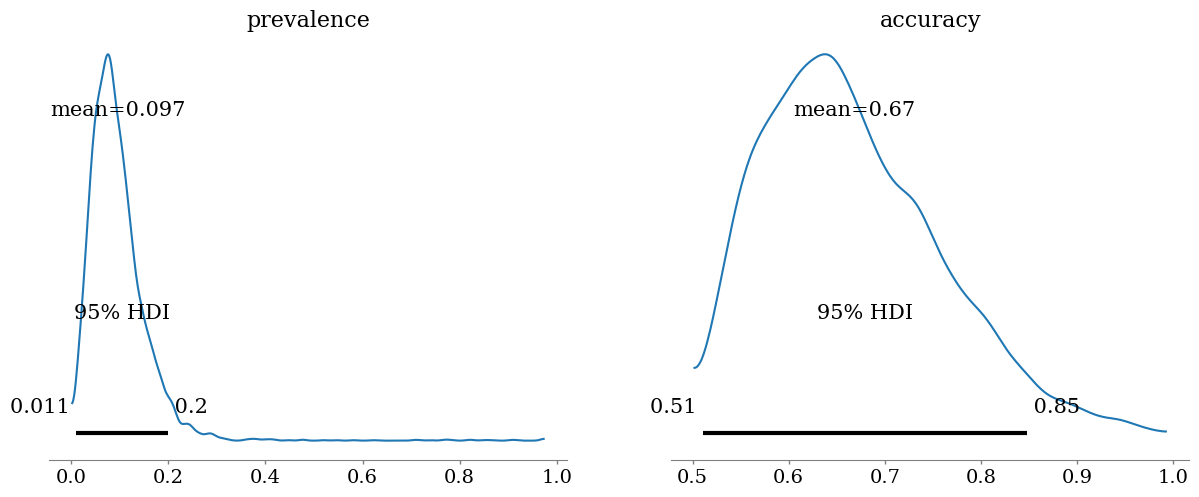

In [4]:
# reproduce mixture model from Veillette et al. eLife. (2024)
with pm.Model() as betabinom_model:

    # prio on population prevalence
    prop_above_chance = pm.Uniform('prevalence', 0., 1.)

    # chance distribution
    chance_logl = pm.logp(pm.Binomial.dist(n = n_trials, p = 0.5), df.correct.to_numpy())

    # above-chance distribution
    a = pm.Exponential('a', 1.0)
    b = pm.Exponential('b', 0.5) 
    _p = pm.Beta('_p', a, b)
    p = .5 + _p/2
    _ = pm.Deterministic('accuracy', .5 + (a / (a + b))/2)
    above_chance_logl = pm.logp(pm.Binomial.dist(n = n_trials, p = p), df.correct.to_numpy())
    
    # marginalize over binomial distribution
    chance_logp = pm.math.log(1 - prop_above_chance) + chance_logl
    above_chance_logp = pm.math.log(prop_above_chance) + above_chance_logl
    logp_marg = pm.logaddexp(chance_logp, above_chance_logp)
    

    # evaluate log-probs w/ non-sampled Potential 
    potential = pm.Potential('likelihood', logp_marg)
    # but keep track of probability each observation is from H1 dist
    pm.Deterministic('logp_H1', above_chance_logp - logp_marg)

    betabinom_trace = pm.sample(
            draws = 1000,
            chains = 5,
            cores = 5,
            random_seed = 1
        )

az.plot_posterior(betabinom_trace, var_names = ['prevalence', 'accuracy'], hdi_prob = .95)
plt.show()

If we just wanted to estimate the population prevalence, we could instead use the `p2prev.PCurveMixture` class to estimate it from the $p$-values in `df.pval` instead of modelling the observed accuracies directly as above.

In [5]:
from p2prev import PCurveMixture
model = PCurveMixture(df.pval.to_numpy())
model.fit()
model.summary()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 5 jobs)
NUTS: [effect_size, prevalence]


Output()

Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 8 seconds.


Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
effect_size,2.569,0.834,1.022,4.226,0.039,0.027,663.0,266.0,1.01
prevalence,0.103,0.086,0.007,0.208,0.004,0.003,1645.0,690.0,1.00


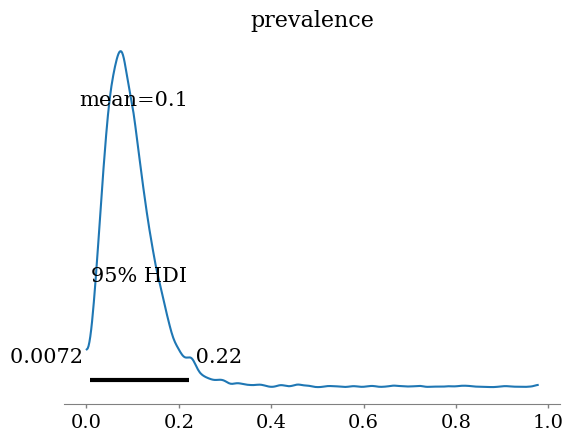

In [6]:
az.plot_posterior(model.mixture, var_names = 'prevalence', hdi_prob = .95)
plt.show()

Nice, we get essentially the same estimate with none of the fuss! Of course, if you can model your observed data directly, that's likely worth doing, as you can improve your estimate by incorporating more meaningful prior information. But it's pretty cool that the same $p$-curve mixture model can be applied to accuracies, to [EEG cluster statistics](https://github.com/john-veillette/p2prev/blob/main/simulations/viz.ipynb), or to essentially any other distribution of data where one could use a null-hypothesis significance test. 

## Estimating posterior probability that individual subjects are above-chance

One thing the beta-binomial model above can do that the `p2prev.PCurveMixture` class can't is estimate $\mathbb{P}(\mathbb{I}_i[H_1])$, the posterior probability each individual subject $i$ comes from the $H_1$ distribution. 

In [7]:
# get posterior probability of H1 being true for each individual subject
p_H1_betabinom = np.exp(betabinom_trace.posterior.logp_H1.values).mean(0).mean(0)
# make sure we get same accuracy "cutoff" as Veillette et al. report:
# (this only means anything in the context of their analysis, but
# is a good check to make sure our implementation gives same results)
print(df.accuracy[p_H1_betabinom < .05].max())

0.5416666666666666


That's functionality isn't currently pre-implemented in `p2prev.PCurveMixture`, since we rely on `pm.Mixture` for automatic marginalization, which doesn't keep track of the individual mixture assignments. (A future PyMC version will probably add improved automatic marginalization in the future, but this is [experimental](https://www.pymc.io/projects/examples/en/latest/howto/marginalizing-models.html) at time of writing. I'll try to update `p2prev.PCurveMixture` when the feature is incorporated into the main package as long as it doesn't slow down sampling.)

But that's a limitation of my code, not of the $p$-curve mixture model itself! Here's how you can do it working with PyMC directly.  

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 5 jobs)
NUTS: [prevalence, effect_size]


Output()

Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 7 seconds.


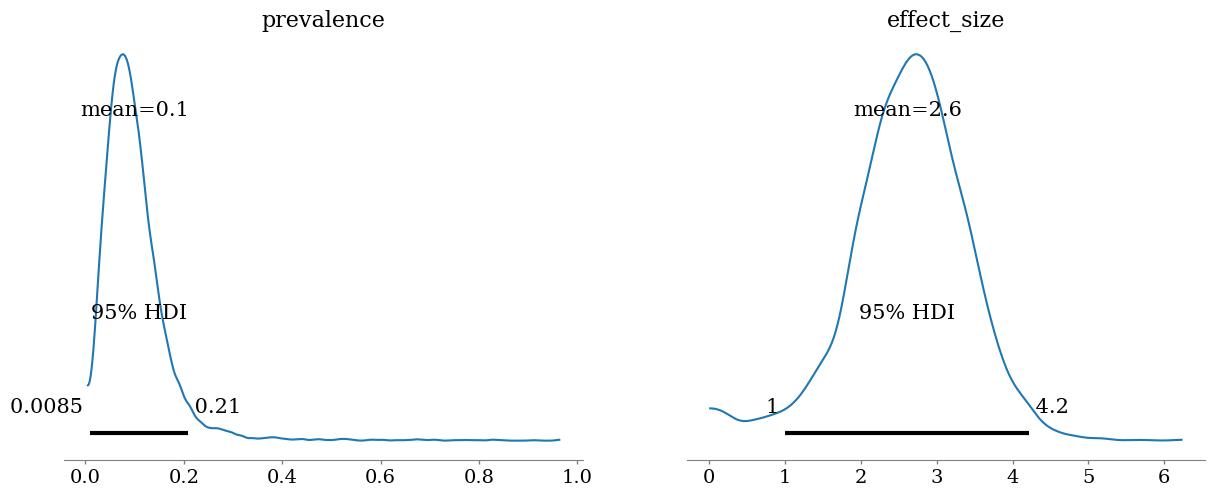

In [8]:
with pm.Model() as pcurve_model:

    # prior for effect size scale under H1
    prior_mean = 1.5 
    # prior on prevalence of H1 under mixture model
    prev = pm.Uniform('prevalence', 0, 1)

    # mixture components
    delta = pm.Exponential('effect_size', 1/prior_mean)
    pcurve_H1 = pm.CustomDist.dist(delta, logp = p_curve_loglik)
    pcurve_H0 = pm.Uniform.dist(0, 1)

    # marginalize over Bernoulli manually (instead of automatically 
    # with pm.Mixture as we do inside the p2prev.PCurveMixture class)
    H0_logl = pm.logp(pcurve_H0, df.pval.to_numpy()) 
    H1_logl = pm.logp(pcurve_H1, df.pval.to_numpy()) 
    H0_logp = pm.math.log(1 - prev) + H0_logl
    H1_logp = pm.math.log(prev) + H1_logl
    logp_marg = pm.logaddexp(H0_logp, H1_logp)

    # evaluate log-probs w/ non-sampled Potential 
    potential = pm.Potential('likelihood', logp_marg)
    # but keep track of probability each observation is from H1 dist
    pm.Deterministic('logp_H1', H1_logp - logp_marg)

    pcurve_trace = pm.sample(
            draws = 1000,
            chains = 5,
            cores = 5,
            random_seed = 1
        )

az.plot_posterior(pcurve_trace, var_names = ['prevalence', 'effect_size'], hdi_prob = .95)
plt.show()

In [9]:
# extract subject-level probabilities
p_H1_pcurve = np.exp(pcurve_trace.posterior.logp_H1.values).mean(0).mean(0)
# reproduce "cutoff" from Veillette et al. 
print(df.accuracy[p_H1_pcurve < .05].max())

0.5416666666666666


Let's visualize the results:

/home/johnv/repos/p2prev/p2prev/pcurve.py:11: RuntimeWarning: invalid value encountered in divide
  return norm.pdf(Z, loc = delta) / norm.pdf(Z, loc = 0)


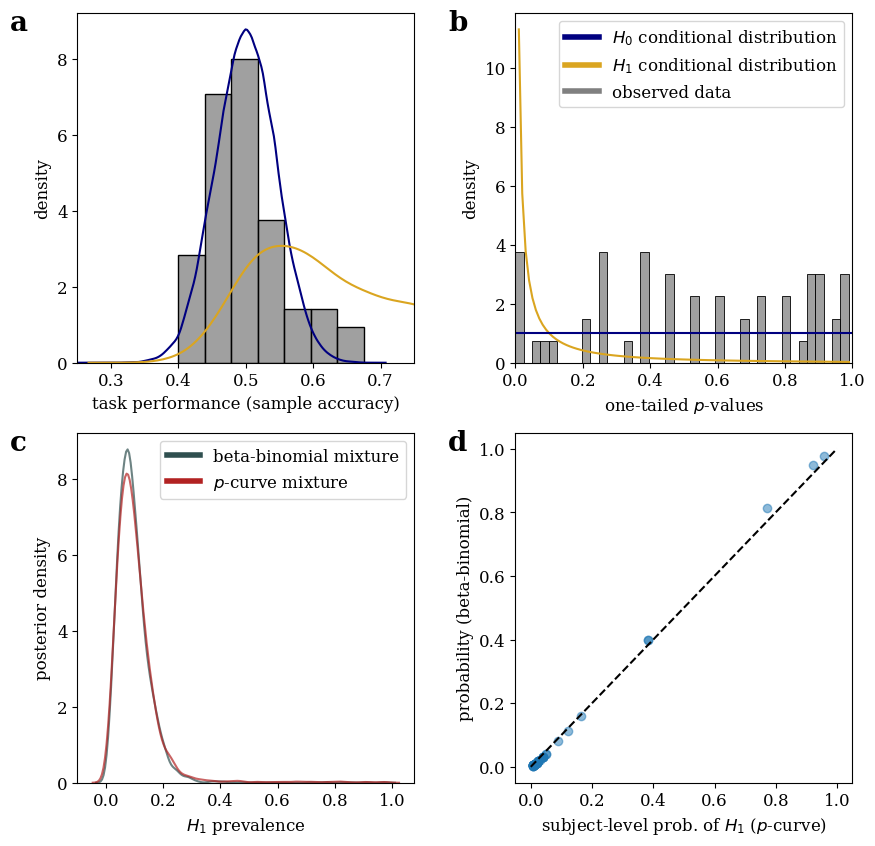

In [10]:
from scipy.stats import binom, beta
from p2prev.pcurve import p_curve_lik

def add_label(ax, label, x_offset):
    xmin, xmax = ax.get_xlim()
    xscale = xmax - xmin
    ymin, ymax = ax.get_ylim()
    yscale = ymax - ymin
    ax.text(
        xmin - x_offset * xscale, ymax - .05 * yscale, 
        label, size = 20, weight = 'bold'
    )

# draw posterior predictive samples
trc = betabinom_trace.stack(sample = ['chain', 'draw'])
a = trc.posterior.a.values
b = trc.posterior.b.values
p = .5 + beta.rvs(a, b, random_state = 0)/2
k = binom.rvs(n_trials, p, random_state = 1) / n_trials
k_binom = binom.rvs(n_trials, .5, size = 50000, random_state = 2) / n_trials
x = np.linspace(0, 1)
## and plot
fig = plt.figure(figsize = (10, 10))
gs = gridspec.GridSpec(2, 2, wspace = .3, hspace = .2)
ax = fig.add_subplot(gs[0, 0])
ax0 = ax
sns.histplot(df.accuracy, stat = 'density', color = 'gray', ax = ax)
sns.kdeplot(k_binom, color = 'navy', ax = ax)
sns.kdeplot(k, color = 'goldenrod', ax = ax)
ax.set_xlim(.25, .75)
ax.set_xlabel('task performance (sample accuracy)')
ax.set_ylabel('density')


ax = fig.add_subplot(gs[0, 1])
ax1 = ax
# plot posterior mean p-curve for H1
x = np.linspace(0, 1, 100)
ys = [p_curve_lik(x, delta) for delta in model.effect_size]
ys = np.stack(ys)
ax.plot(x, ys.mean(0), color = 'goldenrod')
# and p-curve for null is just uniform
ax.plot([0, 1], [1, 1], color = 'navy')
ax.set_xlim(0, 1)
sns.histplot(df.pval, stat = 'density', color = 'gray', ax = ax, bins = 40)
ax.set_xlabel(r'one-tailed $p$-values')
ax.set_ylabel('density')
# make legend
custom_lines = [Line2D([0], [0], color = 'navy', lw = 4),
                Line2D([0], [0], color = 'goldenrod', lw = 4),
                Line2D([0], [0], color = 'gray', lw = 4),
               ]
ax.legend(
    custom_lines, 
    [r'$H_0$ conditional distribution', '$H_1$ conditional distribution', 
     'observed data'
    ],
    loc = 'upper right'
)

ax = fig.add_subplot(gs[1, 0])
ax2 = ax
sns.kdeplot(
    trc.posterior.prevalence.values, 
    ax = ax, 
    color = 'darkslategray', 
    alpha = .7
)
sns.kdeplot(
    model.prevalence, 
    ax = ax, 
    color = 'firebrick', 
    alpha = .7
)
custom_lines = [Line2D([0], [0], color = 'darkslategray', lw = 4),
                Line2D([0], [0], color = 'firebrick', lw = 4)]
ax.legend(
    custom_lines, 
    ['beta-binomial mixture', r'$p$-curve mixture', ],
    loc = 'upper right'
)
ax.set_xlabel(r'$H_1$ prevalence')
ax.set_ylabel(r'posterior density')

ax = fig.add_subplot(gs[1, 1])
ax3 = ax
plt.scatter(p_H1_pcurve, p_H1_betabinom, alpha = .5)
plt.xlabel(r'subject-level prob. of $H_1$ ($p$-curve)')
plt.ylabel(r'probability (beta-binomial)')
plt.plot([0, 1], [0, 1], linestyle = '--', color = 'black')

add_label(ax0, 'a', .2)
add_label(ax1, 'b', .2)
add_label(ax2, 'c', .2)
add_label(ax3, 'd', .2)

if not os.path.exists('figures'):
    os.mkdir('figures')
fpath = os.path.join('figures', 'betabinom.jpeg')
plt.savefig(fpath, dpi = 500, bbox_inches = 'tight')
plt.show()

And once again, the $p$-curve model produces essentially identical results to the domain-specific model!